# Modelo de previsão de interrupção de energia

Uma ocorrencia de energia pode ser acarretada por diversos fatores, sejam externos ou internos, programadas ou não programadas.

Desta forma, o objetivo aqui é criar uma maneira automática para identificação de interrupção de energia, de modo a auxiliar distribuidoras de energia no trabalho proativo para evitar maiores transtornos aos clientes


## Objetivo
O objetivo é identificar variáveis importantes e definir o melhor modelo analítico para inferir na previsibilidade de interrupção de energia.

Esta análise será dividida em 5 macro etapas:
1. Exploratory Data Analysis (EDA)
2. Data Pre-Processing
3. Feature engineering
4. Modeling
5. Hyperparameter tunning

In [1]:
# Dataframe
#from google.cloud import bigquery
#from google.colab import data_table
#import pandas_gbq as gbq

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# Others
from datetime import datetime

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split

## Sobre o Dataset
Abaixo temos maiores detalhes a respeito do dataset:
- `distribuidora`: Nome ficticio da distribuidora de energia em questão
- `ocorrencia`: ID da ocorrencia gerado no sistema interno da distribuidora
- `idConjunto`: ID do conjunto elétrico, caracterizado por um conjunto de elementos elétricos
- `canalAtendimento`: Canal de atendimento na qual a ocorrencia foi registrada
- `inicioOcorrencia`: Data de inicio em que a ocorrencia foi registrada no sistema
- `fimOcorrencia`: Data de finalização da ocorrencia no sistema
- `duracaoOcorrencia`: Duranção da ocorrencia
- `descricaoOcorrencia`: Descrição da ocorrencia
- `NumInterrupcao`: ID da interrupção (caso tenha acontecido)
- `OrdemInterrupcao`:
- `tipoInterrupcao`: Descreve o tipo da interrupção
- `idMotivoInterrupcao`: ID do motivo da interrupção
- `inicioInterrupcao`: Data do inicio da interrupção registrada no sistema
- `fimInterrupcao`: Data do fim da interrupção registrada no sistema
- `duracaoInterrupcao`: Duranção da interrupção
- `causaRaiz`: Causa raíz da interrupção
- `QtdConsAtivo`: Quantidade de consumidores ativos
- `mesUltimaInspecao`: Mes da ultima inspeção de rede daquele conjunto elétrico
- `anoUltimaInspecao`: Ano da ultima inspeção de rede daquele conjunto elétrico
- `mesUltimaManutencaoPrev`: Mes da ultima manutenção preventiva de rede daquele conjunto elétrico
- `anoUltimaManutencaoPrev`: Ano da ultima manutenção preventiva de rede daquele conjunto elétrico
- `mesUltimaManutencaoCorr`: Mes da ultima manutenção corretiva de rede daquele conjunto elétrico
- `anoUltimaManutencaoCorr`: Ano da ultima manutenção corretiva de rede daquele conjunto elétrico
- `isInterrupcao`: Flag que destaca se houve uma interrupção de energia

### Fonte dos dados:
- Percentual de carregamento, dados de inspeção, manutenção e etc.
https://dadosabertos.aneel.gov.br/dataset/indger-indicadores-gerenciais-da-distribuicao


- DEC e FEC
https://dadosabertos.aneel.gov.br/dataset/indicadores-coletivos-de-continuidade-dec-e-fec

- Ocorrência
https://dadosabertos.aneel.gov.br/dataset/ocorrencias-emergenciais-nas-redes-de-distribuicao


- Interrupção do cliente
https://dadosabertos.aneel.gov.br/dataset/interrupcoes-de-energia-eletrica-nas-redes-de-distribuicao

In [2]:
# Google BigQuery
# sql = """ SELECT * FROM `tcc-usp-esalq-007.consumer_layer.tb_dados_finais` """
# df_tecnico = gbq.read_gbq(sql, project_id='tcc-usp-esalq-007')

df_tecnico = pd.read_csv('dataset/dados_finais.csv')
df_tecnico.head(3)

,distribuidora,ocorrencia,idConjunto,canalAtendimento,InicioOcorrencia,FimOcorrencia,duracaoOcorrencia,descricaoOcorrencia,NumInterrupcao,OrdemInterrupcao,tipoInterrupcao,idMotivoInterrupcao,inicioInterrupcao,fimInterrupcao,duracaoInterrupcao,causaRaiz,QtdConsAtivo,mesUltimaInspecao,anoUltumaInspecao,mesUltimaManutencaoPrev,anoUltimaManutencaoPrev,mesUltimaManutencaoCorr,anoUltimaManutencaoCorr,isInterrupcao
0,ERSA,2023-1383662,13569,Callcenter,2023-11-09 14:58:00 UTC,2023-11-10 10:14:00 UTC,1156,Interna;Nao Programada;Nao Classificada,S/I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7300.0,12.0,2023.0,9.0,2023.0,9.0,2023.0,N
1,ERSA,2023-620028,13569,Callcenter,2023-05-27 15:25:00 UTC,2023-05-27 21:42:00 UTC,377,Interna;Nao Programada;Terceiros;Defeito Inter...,S/I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7300.0,12.0,2023.0,9.0,2023.0,9.0,2023.0,N
2,ERSA,2023-1271406,13569,Callcenter,2023-10-23 12:37:00 UTC,2023-10-23 21:49:00 UTC,552,Interna;Nao Programada;Proprias do Sistema;Nao...,S/I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7300.0,12.0,2023.0,9.0,2023.0,9.0,2023.0,N


## Leitura do dataset climático
Abaixo temos maiores detalhes a respeito do dataset:
- `DATA_OBSERVACAO`: Data de medição das métricas climáticas (UTC)
- `HORA_UTC`: Horario de medição das métricas climáticas (UTC)
- `DISTRIBUIDORA`: Distribuidora de energia que contem a consessao da regiao
- `PRECIPITACAO`: Precipitacao medida (chuva) em mm
- `PRESSAO_ATMOSFERICA`: Pressao atmosferica medida (mB)
- `RADIACAO_GLOBAL`: Radiacao solar medida (KJ/m≤)
- `TEMPERATURA_AR`: Temperatura do ar medida (∞C)
- `UMIDADE_RELATIVA_AR`: Umidade relativa do ar medida (%)
- `VENTO_DIRECAO_HORARIA`: Vento na direcao horaria medida (∞(gr))
- `VENTO_RAJADA_MAXIMA`: Vento de rajada maximo (m/s)
- `VENTO_VELOCIDADE_HORARIA`: Velocidade do vento na direcao horaria (m/s)


Fonte dos dados:
- https://portal.inmet.gov.br/dadoshistoricos

In [3]:
# Google BigQuery
# sql = """ SELECT * FROM `tcc-usp-esalq-007.consumer_layer.tb_dados_climaticos` """
# df_clima = gbq.read_gbq(sql, project_id='tcc-usp-esalq-007')

df_clima = pd.read_csv('dataset/tb_dados_climaticos.csv')
df_clima.head(3)

,DATA_OBSERVACAO,HORA_UTC,DISTRIBUIDORA,PRECIPITACAO,PRESSAO_ATMOSFERICA,RADIACAO_GLOBAL,TEMPERATURA_AR,UMIDADE_RELATIVA_AR,VENTO_DIRECAO_HORARIA,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_HORARIA
0,2024-09-05,2,NDBSA,0.0,0.0,0.0,0.0,0,0,0.0,0.0
1,2024-03-22,0,NDBSA,0.0,887.1,0.0,21.5,91,282,1.8,0.3
2,2023-03-11,4,NDBSA,0.0,886.4,0.0,17.7,90,282,2.3,0.3


## Tratamento de dados
#### Conversão de tipos
- `DATA_OBSERVACAO`: converte para datetime
- `HORA_UTC`: converte para inteiro


#### Criação de novas features
- `DATETIME_UTC`: DATA_OBSERVACAO convertido em UTC
- `DATETIME_BRT`: DATA_OBSERVACAO convertido em UTC-3
- `HORA`: Hora da observação
- `DIA_DA_SEMANA`: Dia da semana da observação
- `MES`: Mes da observação
- `FIM_DE_SEMANA`: Verifica se o evento medido foi no final de semana

In [4]:
# Converter DATA_OBSERVACAO para datetime
df_clima['DATA_OBSERVACAO'] = pd.to_datetime(df_clima['DATA_OBSERVACAO'])

# Converter HORA_UTC para inteiro
df_clima['HORA_UTC'] = df_clima['HORA_UTC'].astype(int)

# Criar timestamp UTC
df_clima['DATETIME_UTC'] = df_clima['DATA_OBSERVACAO'] + pd.to_timedelta(df_clima['HORA_UTC'], unit='h')
df_clima['DATETIME_UTC'] = df_clima['DATETIME_UTC'].dt.tz_localize('UTC')  # Adiciona fuso UTC

# Converter para horário de Brasília (BRT = UTC-3)
df_clima['DATETIME_BRT'] = df_clima['DATETIME_UTC'].dt.tz_convert('America/Sao_Paulo')

# Criar features temporais
#df_clima['HORA'] = df_clima['DATETIME_BRT'].dt.hour  # Hora do dia
#df_clima['DIA_DA_SEMANA'] = df_clima['DATETIME_BRT'].dt.weekday  # Segunda=0, Domingo=6
#df_clima['MES'] = df_clima['DATETIME_BRT'].dt.month  # Mês do ano
#df_clima['FIM_DE_SEMANA'] = (df_clima['DIA_DA_SEMANA'] >= 5).astype(int)  # 1 se sábado/domingo

#### Agregação do dataset de clima

In [5]:
# Agregação dos dados climáticos por hora e distribuidora
df_clima_aggregated = df_clima.groupby(['DATETIME_BRT', 'DISTRIBUIDORA']).agg({
    'PRECIPITACAO': 'max',
    'PRESSAO_ATMOSFERICA': 'max',
    'RADIACAO_GLOBAL': 'max',
    'TEMPERATURA_AR': 'max',
    'UMIDADE_RELATIVA_AR': 'max',
    'VENTO_DIRECAO_HORARIA': 'max',
    'VENTO_RAJADA_MAXIMA': 'max',
    'VENTO_VELOCIDADE_HORARIA': 'max',
}).reset_index()

# Verificando as primeiras linhas para garantir que a agregação está correta
df_clima_aggregated.tail()

,DATETIME_BRT,DISTRIBUIDORA,PRECIPITACAO,PRESSAO_ATMOSFERICA,RADIACAO_GLOBAL,TEMPERATURA_AR,UMIDADE_RELATIVA_AR,VENTO_DIRECAO_HORARIA,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_HORARIA
35083,2024-12-31 18:00:00-03:00,NDBSA,0.0,884.3,877.0,21.7,84,3,12.1,3.4
35084,2024-12-31 19:00:00-03:00,ERSA,0.0,925.9,81.0,22.2,90,165,6.6,2.1
35085,2024-12-31 19:00:00-03:00,NDBSA,0.0,884.5,109.8,21.3,89,356,5.3,2.5
35086,2024-12-31 20:00:00-03:00,ERSA,0.0,926.3,0.0,21.6,89,161,5.6,1.4
35087,2024-12-31 20:00:00-03:00,NDBSA,0.0,885.5,0.0,20.8,90,1,4.6,1.9


#### Agregando dados técnicos a dados climáticos

In [6]:
# Garantindo que a coluna 'InicioOcorrencia' do df_tecnico esteja no timezone correto (UTC-3)
df_tecnico['InicioOcorrencia'] = pd.to_datetime(df_tecnico['InicioOcorrencia']).dt.tz_convert('America/Sao_Paulo')

# Arredondando os minutos de 'InicioOcorrencia' para o intervalo completo de horas
df_tecnico['InicioOcorrencia'] = df_tecnico['InicioOcorrencia'].dt.floor('h')

# Merge entre df_clima_aggregated e df_tecnico, priorizando os dados do df_tecnico
df = pd.merge(df_tecnico, df_clima_aggregated, how='left',
                     left_on=['InicioOcorrencia', 'distribuidora'],
                     right_on=['DATETIME_BRT', 'DISTRIBUIDORA']) 

# Verificando as primeiras linhas após o merge
df.head()

,distribuidora,ocorrencia,idConjunto,canalAtendimento,InicioOcorrencia,FimOcorrencia,duracaoOcorrencia,descricaoOcorrencia,NumInterrupcao,OrdemInterrupcao,tipoInterrupcao,idMotivoInterrupcao,inicioInterrupcao,fimInterrupcao,duracaoInterrupcao,causaRaiz,QtdConsAtivo,mesUltimaInspecao,anoUltumaInspecao,mesUltimaManutencaoPrev,anoUltimaManutencaoPrev,mesUltimaManutencaoCorr,anoUltimaManutencaoCorr,isInterrupcao,DATETIME_BRT,DISTRIBUIDORA,PRECIPITACAO,PRESSAO_ATMOSFERICA,RADIACAO_GLOBAL,TEMPERATURA_AR,UMIDADE_RELATIVA_AR,VENTO_DIRECAO_HORARIA,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_HORARIA
0,ERSA,2023-1383662,13569,Callcenter,2023-11-09 11:00:00-03:00,2023-11-10 10:14:00 UTC,1156,Interna;Nao Programada;Nao Classificada,S/I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7300.0,12.0,2023.0,9.0,2023.0,9.0,2023.0,N,2023-11-09 11:00:00-03:00,ERSA,0.0,926.5,3550.8,32.4,35,335,8.7,4.3
1,ERSA,2023-620028,13569,Callcenter,2023-05-27 12:00:00-03:00,2023-05-27 21:42:00 UTC,377,Interna;Nao Programada;Terceiros;Defeito Inter...,S/I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7300.0,12.0,2023.0,9.0,2023.0,9.0,2023.0,N,2023-05-27 12:00:00-03:00,ERSA,0.0,930.4,3052.0,25.3,47,319,7.3,3.4
2,ERSA,2023-1271406,13569,Callcenter,2023-10-23 09:00:00-03:00,2023-10-23 21:49:00 UTC,552,Interna;Nao Programada;Proprias do Sistema;Nao...,S/I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7300.0,12.0,2023.0,9.0,2023.0,9.0,2023.0,N,2023-10-23 09:00:00-03:00,ERSA,0.0,927.7,2399.7,23.1,71,109,4.4,1.7
3,ERSA,2023-1168401,13570,Callcenter,2023-10-03 14:00:00-03:00,2023-10-04 00:25:00 UTC,438,Interna;Nao Programada;Terceiros;Defeito Inter...,2023-1168401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30936.0,6.0,2023.0,9.0,2023.0,9.0,2023.0,Y,2023-10-03 14:00:00-03:00,ERSA,0.0,922.8,2879.6,28.0,61,335,6.3,2.5
4,ERSA,2023-121412,13570,Callcenter,2023-01-28 10:00:00-03:00,2023-01-28 15:57:00 UTC,130,Interna;Nao Programada;Terceiros;Defeito Inter...,S/I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30936.0,6.0,2023.0,9.0,2023.0,9.0,2023.0,N,2023-01-28 10:00:00-03:00,ERSA,0.0,928.3,3074.1,27.3,62,325,7.7,3.8


#### Criando flag de precipitação

In [7]:
# Se houve chuva, 1 senão 0
df['flag_precipitation'] = (df['PRECIPITACAO'] > 0).astype(int)
df['flag_precipitation'].value_counts()

0    597499
1     98947
Name: flag_precipitation, dtype: int64

In [8]:
# Convert isInterrupcao em Numerico
df['isInterrupcao'] = df['isInterrupcao'].map({'N': 0, 'Y': 1})

## Exploratory Data Analysis
Visando entender como nossos dados estão se comportando, vamos analisar nossas variaveis, estruturas e tentar entender seus significados e relevâncias em nossa problemática.

### Funções de apoio
Iniciamos definindo algumas funções que poderão abstrair alguns códigos durante nossas análises

In [9]:
def countplot_datas(x_value, df):
  plt.figure(figsize=(10, 6))  # Ajuste o tamanho da figura conforme necessário
  sns.countplot(x=x_value, data=df)
  plt.xticks(rotation=45, ha='right')  # Gira as legendas em 45 graus e alinha à direita
  plt.tight_layout()  # Ajusta o layout para evitar sobreposições
  plt.show()


def countplot_relacao(x_value, hue_value, df):
  plt.figure(figsize=(10, 6))
  sns.countplot(x=x_value, hue=hue_value, data=df)
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

#### Algumas informações a respeito do nosso dataset
- Shape
- Informações do tipo de dados
- Análise descritiva dos dados

In [10]:
# Shape dos dataset
df.shape

(696446, 35)

In [11]:
# Informações relevantes do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 696446 entries, 0 to 696445
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype                            
---  ------                    --------------   -----                            
 0   distribuidora             696446 non-null  object                           
 1   ocorrencia                696446 non-null  object                           
 2   idConjunto                696446 non-null  int64                            
 3   canalAtendimento          696446 non-null  object                           
 4   InicioOcorrencia          696446 non-null  datetime64[ns, America/Sao_Paulo]
 5   FimOcorrencia             696446 non-null  object                           
 6   duracaoOcorrencia         696446 non-null  int64                            
 7   descricaoOcorrencia       696446 non-null  object                           
 8   NumInterrupcao            696446 non-null  object               

In [12]:
# Análise descritiva do dataset
df.describe()

,idConjunto,duracaoOcorrencia,idMotivoInterrupcao,duracaoInterrupcao,QtdConsAtivo,mesUltimaInspecao,anoUltumaInspecao,mesUltimaManutencaoPrev,anoUltimaManutencaoPrev,mesUltimaManutencaoCorr,anoUltimaManutencaoCorr,isInterrupcao,PRECIPITACAO,PRESSAO_ATMOSFERICA,RADIACAO_GLOBAL,TEMPERATURA_AR,UMIDADE_RELATIVA_AR,VENTO_DIRECAO_HORARIA,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_HORARIA,flag_precipitation
count,696446.000000,696446.000000,441284.000000,441284.000000,687092.000000,687092.000000,687092.000000,687092.000000,687092.000000,687092.000000,687092.000000,696446.000000,696446.000000,696446.000000,696446.000000,696446.000000,696446.000000,696446.000000,696446.000000,696446.000000,696446.000000
mean,14233.640994,475.670359,0.730314,427.079779,37573.787414,7.604353,2023.942223,8.826624,2023.942003,8.997443,2023.947505,0.675961,0.388883,923.031345,1158.426894,22.535035,77.460982,218.715737,6.180164,2.349502,0.142074
std,1317.533671,560.818604,1.909877,520.435380,29620.441108,1.504748,0.233321,0.564189,0.247227,0.050504,0.223024,0.468015,2.354968,35.196236,1209.760626,5.157852,20.588182,96.997863,2.856814,1.216945,0.349126
min,12668.000000,6.000000,0.000000,3.000000,2783.000000,3.000000,2023.000000,5.000000,2021.000000,8.000000,2023.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13498.000000,145.000000,0.000000,121.000000,18802.000000,7.000000,2024.000000,9.000000,2024.000000,9.000000,2024.000000,0.000000,0.000000,924.200000,0.500000,19.000000,64.000000,139.000000,4.200000,1.400000,0.000000
50%,13552.000000,283.000000,0.000000,242.000000,32984.000000,8.000000,2024.000000,9.000000,2024.000000,9.000000,2024.000000,1.000000,0.000000,927.100000,716.400000,22.100000,83.000000,203.000000,5.900000,2.200000,0.000000
75%,13608.000000,569.000000,0.000000,503.000000,48681.000000,9.000000,2024.000000,9.000000,2024.000000,9.000000,2024.000000,1.000000,0.000000,930.000000,2214.000000,26.300000,95.000000,323.000000,7.800000,3.100000,0.000000
max,17329.000000,59669.000000,6.000000,17498.000000,264495.000000,12.000000,2024.000000,11.000000,2024.000000,9.000000,2024.000000,1.000000,56.600000,940.900000,3998.600000,37.900000,100.000000,360.000000,25.000000,8.000000,1.000000


#### Dados faltantes

<Axes: >

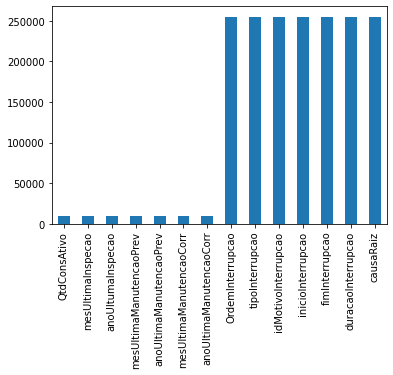

In [13]:
# Plot dos dados faltantes
missingData = df.isnull().sum()
missingData = missingData[missingData > 0]
missingData.sort_values(inplace=True)
missingData.plot.bar()

In [14]:
# Preenchendo os valores NA com a média dos valores
df['TEMPERATURA_AR'] = df['TEMPERATURA_AR'].fillna(df['TEMPERATURA_AR'].mean())
df['PRECIPITACAO'] = df['PRECIPITACAO'].fillna(df['PRECIPITACAO'].mean())
df['UMIDADE_RELATIVA_AR'] = df['UMIDADE_RELATIVA_AR'].fillna(df['UMIDADE_RELATIVA_AR'].mean())
df['VENTO_RAJADA_MAXIMA'] = df['VENTO_RAJADA_MAXIMA'].fillna(df['VENTO_RAJADA_MAXIMA'].mean())
df['QtdConsAtivo'] = df['QtdConsAtivo'].fillna(round(df['QtdConsAtivo'].mean())).astype(int)

In [ ]:
# Plot dos dados faltantes
missingData = df.isnull().sum()
missingData = missingData[missingData > 0]
missingData.sort_values(inplace=True)
missingData.plot.bar()

### Frequência de Interrupções no Conjunto Elétrico
Podemos contar quantas interrupções já ocorreram no mesmo conjunto elétrico (idConjunto) para identificar conjuntos problemáticos.

In [15]:
# Criar a nova feature corretamente
df['historico_interrupcoes_conjunto'] = df.groupby('idConjunto')['isInterrupcao'].transform(lambda x: x.shift().cumsum().fillna(0))

## Relação da chuva com interrupção

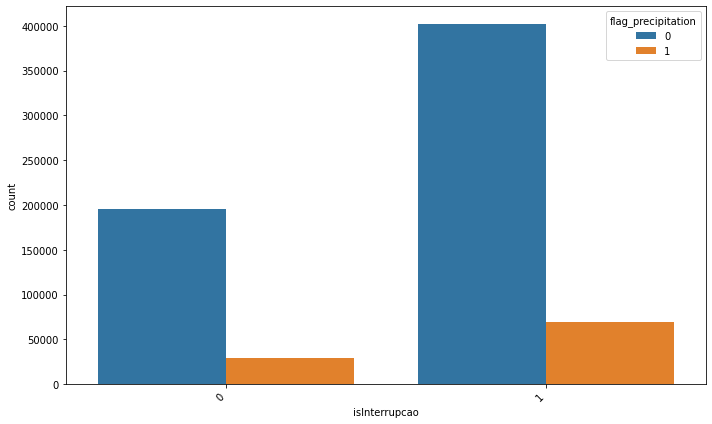

In [16]:
countplot_relacao('isInterrupcao', 'flag_precipitation', df)

## Feature Engineering
### Tempo desde a última inspeção e manutenção
Quantos meses passaram desde a última inspeção e manutenção, pois quanto mais tempo sem manutenção, maior pode ser o risco de interrupção.

In [17]:
# Criar referência do tempo atual (ou considerar a data do evento)
df['ano_atual'] = df['InicioOcorrencia'].dt.year
df['mes_atual'] = df['InicioOcorrencia'].dt.month

# Tempo desde a última inspeção
df['meses_desde_inspecao'] = (df['ano_atual'] - df['anoUltumaInspecao'].astype(float)) * 12 + (df['mes_atual'] - df['anoUltumaInspecao'].astype(float))

# Tempo desde a última manutenção preventiva
df['meses_desde_manut_prev'] = (df['ano_atual'] - df['anoUltimaManutencaoPrev'].astype(float)) * 12 + (df['mes_atual'] - df['mesUltimaManutencaoPrev'].astype(float))

# Tempo desde a última manutenção corretiva
df['meses_desde_manut_corr'] = (df['ano_atual'] - df['anoUltimaManutencaoCorr'].astype(float)) * 12 + (df['mes_atual'] - df['mesUltimaManutencaoCorr'].astype(float))


cols_to_fill = ['meses_desde_inspecao', 'meses_desde_manut_prev', 'meses_desde_manut_corr']

for col in cols_to_fill:
    df[col] = df[col].fillna(df[col].median())

### Deleta features desnecessárias ou redundantes

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 696446 entries, 0 to 696445
Data columns (total 41 columns):
 #   Column                           Non-Null Count   Dtype                            
---  ------                           --------------   -----                            
 0   distribuidora                    696446 non-null  object                           
 1   ocorrencia                       696446 non-null  object                           
 2   idConjunto                       696446 non-null  int64                            
 3   canalAtendimento                 696446 non-null  object                           
 4   InicioOcorrencia                 696446 non-null  datetime64[ns, America/Sao_Paulo]
 5   FimOcorrencia                    696446 non-null  object                           
 6   duracaoOcorrencia                696446 non-null  int64                            
 7   descricaoOcorrencia              696446 non-null  object                           

In [19]:
# cols para deletar
cols = ['distribuidora','idConjunto','canalAtendimento','InicioOcorrencia','FimOcorrencia',
        'descricaoOcorrencia','NumInterrupcao','OrdemInterrupcao','tipoInterrupcao','idMotivoInterrupcao',
        'inicioInterrupcao','fimInterrupcao','duracaoInterrupcao','causaRaiz','mesUltimaInspecao',
        'anoUltumaInspecao','mesUltimaManutencaoPrev','anoUltimaManutencaoPrev','mesUltimaManutencaoCorr',
        'anoUltimaManutencaoCorr','DATETIME_BRT','DISTRIBUIDORA','ano_atual','mes_atual']
df.drop(columns=cols, inplace=True)

## Matriz de correlação

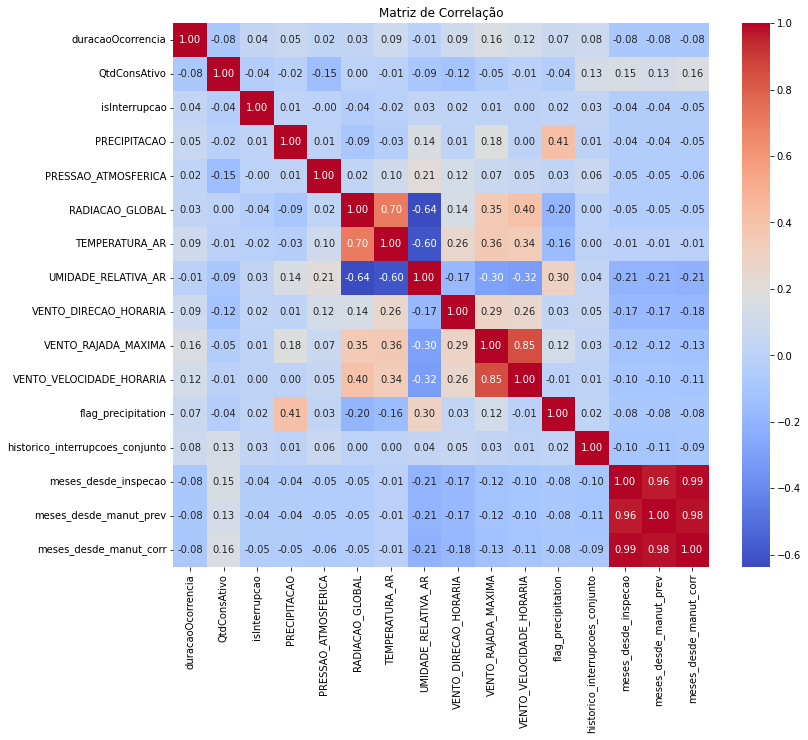

In [20]:
# prompt: gere uma matriz de correlação das variáveis
df_corr = df[df.select_dtypes(include=np.number).columns.tolist()].copy()

# Calcula a matriz de correlação
correlation_matrix = df_corr.corr()

# Plota a matriz de correlação usando um heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

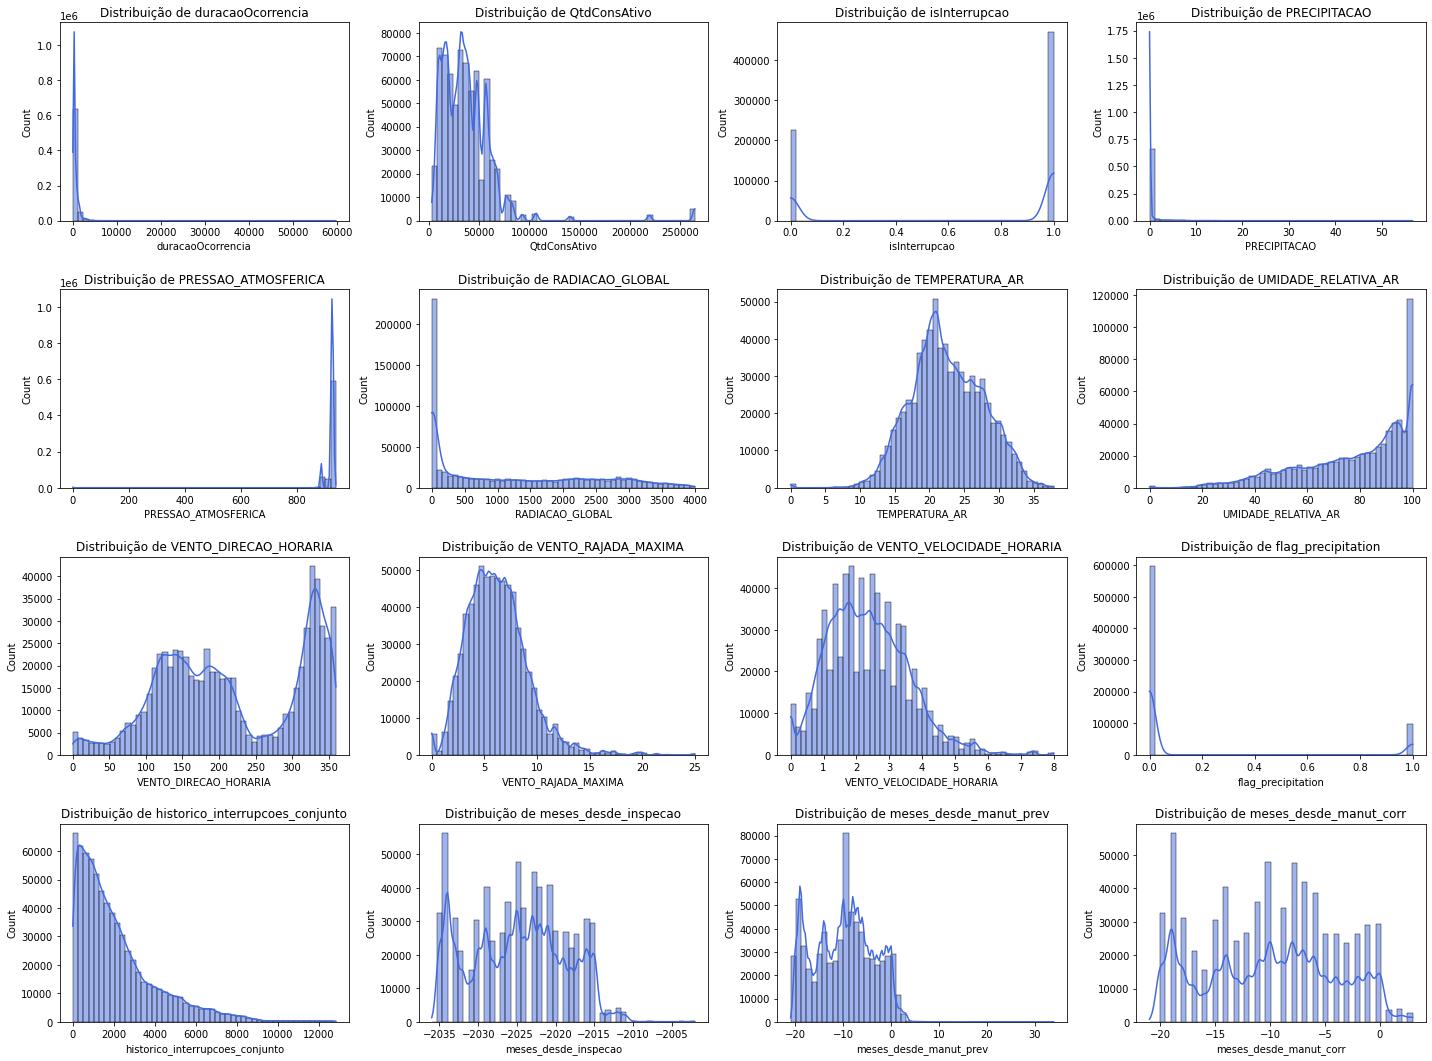

In [21]:
# Assuming df is already defined
num_cols = df.select_dtypes(include=np.number).columns.tolist()

# Create subplots with enough space for 13 plots
fig, axes = plt.subplots(4, 4, figsize=(20, 15))  # 4x4 grid (16 axes)
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color='royalblue')
    axes[i].set_title(f'Distribuição de {col}')

plt.tight_layout()
plt.show()

## Treinamento

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Colunas selecionadas
cols = df.select_dtypes(include=np.number).columns.tolist()

# Obtendo o target
target_column = 'isInterrupcao'  # Substitua pelo nome correto
cols.remove(target_column)

# Dividindo as features e os rótulos
X = df[cols]  # As features (colunas de entrada)
y = df[target_column]  # Os rótulos (coluna alvo)

# Dividir em treino e teste
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando o modelo
#model = RandomForestClassifier(random_state=42)
model = RandomForestClassifier(class_weight="balanced", random_state=42)
model.fit(train_X, train_y)

# Importância das features
importances = pd.Series(model.feature_importances_, index=train_X.columns)
print(importances.sort_values(ascending=False))

duracaoOcorrencia                  0.176045
historico_interrupcoes_conjunto    0.168283
QtdConsAtivo                       0.135611
VENTO_DIRECAO_HORARIA              0.067721
PRESSAO_ATMOSFERICA                0.066211
TEMPERATURA_AR                     0.065611
VENTO_RAJADA_MAXIMA                0.061507
RADIACAO_GLOBAL                    0.060985
VENTO_VELOCIDADE_HORARIA           0.055252
UMIDADE_RELATIVA_AR                0.051019
meses_desde_manut_prev             0.032834
meses_desde_inspecao               0.023273
meses_desde_manut_corr             0.022447
PRECIPITACAO                       0.009273
flag_precipitation                 0.003929
dtype: float64


# Teste

Acurácia: 0.6982
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.57      0.27      0.37     45127
           1       0.72      0.90      0.80     94163

    accuracy                           0.70    139290
   macro avg       0.65      0.59      0.58    139290
weighted avg       0.67      0.70      0.66    139290



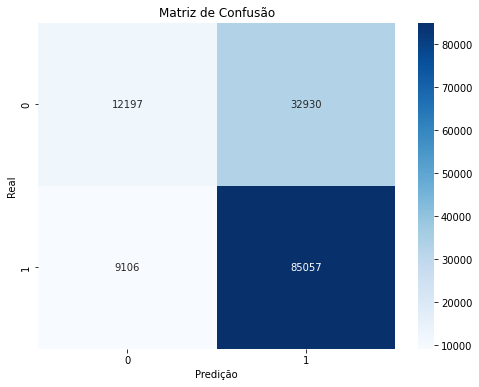

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Previsões no conjunto de teste
y_pred = model.predict(test_X)

# Acurácia
accuracy = accuracy_score(test_y, y_pred)
print(f"Acurácia: {accuracy:.4f}")

# Relatório de classificação (precisão, recall, F1-score)
print("Relatório de Classificação:")
print(classification_report(test_y, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(test_y, y_pred)

# Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


# Explicação das métricas e gráficos:
`Acurácia (accuracy_score)`: A porcentagem de previsões corretas em relação ao total de amostras.
<br><br>

**Relatório de Classificação (classification_report):**<br>
`Precision:` A precisão indica a quantidade de previsões positivas corretas em relação ao total de previsões positivas feitas. Ou seja, é a capacidade do modelo de não classificar incorretamente as amostras negativas como positivas.
<br><br>
`Recall:` O recall indica a capacidade do modelo de capturar todas as instâncias positivas (verdadeiros positivos), ou seja, a quantidade de positivas que foram corretamente identificadas.
<br><br>
`F1-score:` A média harmônica entre precisão e recall, proporcionando uma medida mais balanceada entre ambos. O F1 é especialmente útil quando as classes estão desbalanceadas.
<br><br>
`Matriz de Confusão:` A matriz de confusão mostra o desempenho do modelo, fornecendo os valores de verdadeiro positivo (TP), falso positivo (FP), verdadeiro negativo (TN) e falso negativo (FN). A matriz de confusão ajuda a entender melhor onde o modelo está cometendo erros.

O gráfico de matriz de confusão exibe visualmente esses valores e ajuda a ver onde o modelo pode estar errando (por exemplo, confundindo uma classe com outra).
<br><br>

**Outras métricas:** <br>
`ROC-AUC:` Para problemas de classificação binária, você pode avaliar o desempenho do modelo com a curva ROC e a área sob a curva (AUC). Caso precise disso, posso te ajudar a implementar.

`Log-Loss:` Outra métrica útil para problemas de classificação, especialmente quando você tem probabilidades preditivas em vez de previsões binárias.

#### Acurácia: **0.6815** (ou **68.15%**)
A **acurácia** indica a porcentagem total de previsões corretas feitas pelo modelo. Nesse caso, o modelo acertou cerca de **68.15%** das previsões.

**Nota**: A acurácia por si só pode ser **enganosa** quando as classes são desbalanceadas, o que parece ser o caso aqui, já que a classe `1.0` tem muito mais exemplos (94.260) que a classe `0.0` (45.030).

#### Relatório de Classificação

##### Classe 0.0 (classe negativa)
- **Precision (Precisão)**: **0.51**  
  Indica que, quando o modelo previu a classe `0.0`, ele estava correto **51%** das vezes.

- **Recall (Revocação ou Sensibilidade)**: **0.39**  
  O modelo conseguiu identificar **39%** de todas as amostras reais de classe `0.0`, ou seja, perdeu **61%** das amostras da classe `0.0`.

- **F1-score**: **0.44**  
  O F1-score de **0.44** indica um equilíbrio entre precisão e recall, mas o modelo ainda pode melhorar para a classe `0.0`.

##### Classe 1.0 (classe positiva)
- **Precision (Precisão)**: **0.74**  
  Quando o modelo previu a classe `1.0`, ele estava correto **74%** das vezes.

- **Recall (Revocação ou Sensibilidade)**: **0.82**  
  O modelo conseguiu identificar **82%** das amostras reais de classe `1.0`, o que é muito bom para essa classe.

- **F1-score**: **0.78**  
  O F1-score de **0.78** para a classe `1.0` mostra que o modelo tem um bom equilíbrio entre precisão e recall.

#### Médias

- **Macro avg** (média das métricas sem considerar o desequilíbrio de classes):
  - **Precision**: **0.62**
  - **Recall**: **0.61**
  - **F1-score**: **0.61**

- **Weighted avg** (média ponderada considerando o tamanho de cada classe):
  - **Precision**: **0.66**
  - **Recall**: **0.68**
  - **F1-score**: **0.67**

#### Conclusões
- **Classe 1.0**: O modelo está indo muito bem para a classe `1.0` (boa precisão e recall).
- **Classe 0.0**: A classe `0.0` é onde o modelo tem dificuldades, especialmente em termos de recall (ele está perdendo muitos exemplos de `0.0`).

### Próximos Passos para Melhorar o Modelo

1. **Balanceamento de Classes**
   - Como a classe `1.0` é muito maior do que a classe `0.0`, isso pode afetar o modelo. Considere técnicas como:
     - **Oversampling** (aumentar o número de amostras da classe minoritária) com técnicas como **SMOTE**.
     - **Undersampling** (reduzir o número de amostras da classe majoritária).
     - **Ajustar os pesos das classes** dentro do modelo usando o parâmetro `class_weight='balanced'` no `RandomForestClassifier`.

2. **Ajuste de Hiperparâmetros**
   - Experimente ajustar os **hiperparâmetros** do modelo (como o número de árvores, a profundidade máxima das árvores, etc.) para tentar melhorar o desempenho.

3. **Analisar Mais Features**
   - Verifique se há mais variáveis relevantes que podem ser adicionadas ao modelo. Adicionar novas variáveis ou transformar as existentes pode melhorar o desempenho.

4. **Técnicas de Ensemble**
   - Experimente outros métodos de ensemble, como **Gradient Boosting** ou **XGBoost**, para melhorar o desempenho.

5. **Acurácia de Classificação**
   - Se estiver lidando com **classes desbalanceadas**, a **acurácia** pode não ser a métrica mais confiável. Dê mais atenção a **precision**, **recall** e **F1-score**, especialmente para a classe minoritária.

---

**Dica:** Quando o modelo apresenta uma grande diferença entre o desempenho nas classes (alta precisão e recall para `1.0`, mas baixa para `0.0`), o **balanceamento de classes** pode ser uma solução eficaz.


# XGBoost
### Parametrização default

Acurácia: 0.6928

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.63      0.13      0.21     45135
           1       0.70      0.96      0.81     94155

    accuracy                           0.69    139290
   macro avg       0.66      0.55      0.51    139290
weighted avg       0.68      0.69      0.62    139290



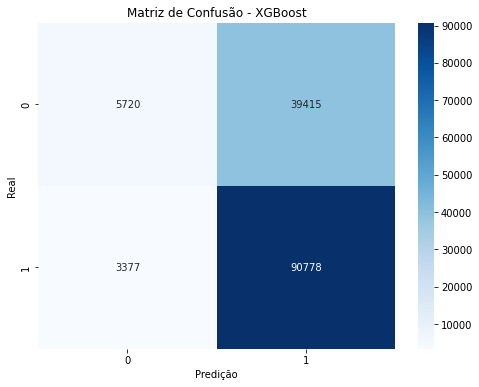

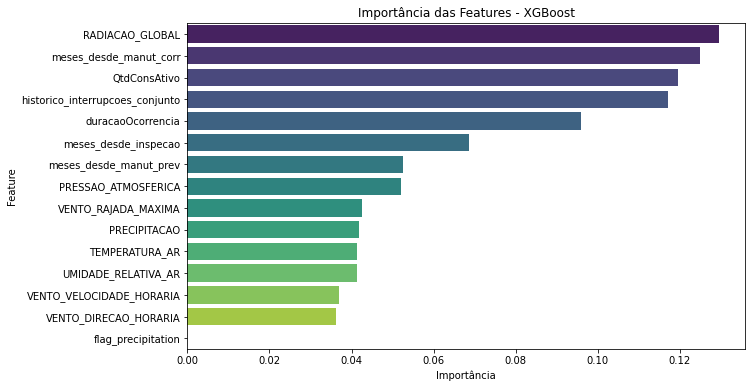


🔹 XGBoost - Acurácia Média (Validação Cruzada): 0.6654 (+/- 0.0266)


In [30]:
# 📌 Importando bibliotecas
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Selecionando apenas as features numéricas (removendo o target)
target_column = 'isInterrupcao'  # Substitua pelo nome correto
cols = df.select_dtypes(include=np.number).columns.tolist()
cols.remove(target_column)

# 📌 Separação entre features e target
X = df[cols]  
y = df[target_column]  

# 📌 Dividir os dados em treino (80%) e teste (20%)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 Calculando `scale_pos_weight` para balanceamento de classes no XGBoost
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

# 📌 Treinar o modelo XGBoost com balanceamento de classes
xgb_model = XGBClassifier(random_state=42)  # Parâmetros default
xgb_model.fit(train_X, train_y)

# 📌 Fazer previsões no conjunto de teste
y_pred = xgb_model.predict(test_X)

# 📌 Avaliação do Modelo
accuracy = accuracy_score(test_y, y_pred)
print(f"Acurácia: {accuracy:.4f}")

print("\nRelatório de Classificação:")
print(classification_report(test_y, y_pred))

# 📌 Matriz de Confusão
conf_matrix = confusion_matrix(test_y, y_pred)

# 📌 Visualizar a Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão - XGBoost')
plt.show()

# 📌 Importância das Features
importances = pd.Series(xgb_model.feature_importances_, index=cols).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:15], y=importances.index[:15], hue=importances.index[:15], palette="viridis")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.title("Importância das Features - XGBoost")
plt.show()

# 📌 Validação Cruzada para checar overfitting
scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
print(f"\n🔹 XGBoost - Acurácia Média (Validação Cruzada): {scores.mean():.4f} (+/- {scores.std():.4f})")

### Patametrizando 

Acurácia: 0.6093

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.43      0.63      0.51     45135
           1       0.77      0.60      0.68     94155

    accuracy                           0.61    139290
   macro avg       0.60      0.61      0.59    139290
weighted avg       0.66      0.61      0.62    139290



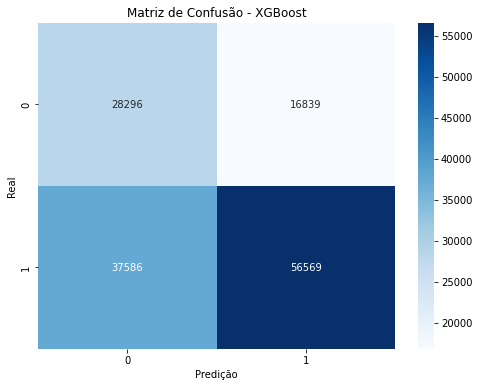

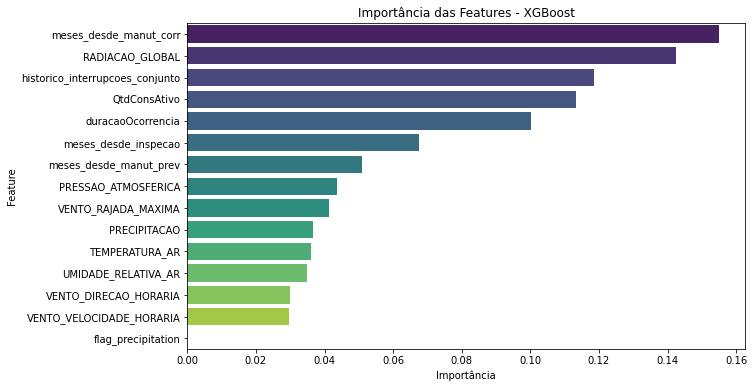


🔹 XGBoost - Acurácia Média (Validação Cruzada): 0.5753 (+/- 0.0643)


In [31]:
# 📌 Importando bibliotecas
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Selecionando apenas as features numéricas (removendo o target)
target_column = 'isInterrupcao'  # Substitua pelo nome correto
cols = df.select_dtypes(include=np.number).columns.tolist()
cols.remove(target_column)

# 📌 Separação entre features e target
X = df[cols]  
y = df[target_column]  

# 📌 Dividir os dados em treino (80%) e teste (20%)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 Calculando `scale_pos_weight` para balanceamento de classes no XGBoost
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

# 📌 Treinar o modelo XGBoost com balanceamento de classes
xgb_model = XGBClassifier(
    n_estimators=200,  # Número de árvores (aumentado para mais estabilidade)
    max_depth=6,  # Profundidade das árvores (ajustável)
    learning_rate=0.1,  # Taxa de aprendizado
    scale_pos_weight=scale_pos_weight,  # Balanceamento das classes
    random_state=42
)
xgb_model.fit(train_X, train_y)

# 📌 Fazer previsões no conjunto de teste
y_pred = xgb_model.predict(test_X)

# 📌 Avaliação do Modelo
accuracy = accuracy_score(test_y, y_pred)
print(f"Acurácia: {accuracy:.4f}")

print("\nRelatório de Classificação:")
print(classification_report(test_y, y_pred))

# 📌 Matriz de Confusão
conf_matrix = confusion_matrix(test_y, y_pred)

# 📌 Visualizar a Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão - XGBoost')
plt.show()

# 📌 Importância das Features
importances = pd.Series(xgb_model.feature_importances_, index=cols).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:15], y=importances.index[:15], hue=importances.index[:15], palette="viridis")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.title("Importância das Features - XGBoost")
plt.show()

# 📌 Validação Cruzada para checar overfitting
scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
print(f"\n🔹 XGBoost - Acurácia Média (Validação Cruzada): {scores.mean():.4f} (+/- {scores.std():.4f})")

### Resultado da comparação
#### Analisando os Resultados


| Modelo   | Acurácia | Precision - 0 | Recall - 0 | Precision - 1 | Recall - 1 | F1-Score - 0 | F1-Score - 1 |
| -------- | -------- | ------------- | ---------- | ------------- | ---------- | ------------ | ------------ |
| Default  | 69,28%   | 63%           | 13%        | 70%           | 96%        | 21%          | 81%          | 
| Parametrizado | 60,93% | 43%        | 63%        | 77%           | 60%        | 51%          | 68%          |


#### O que mudou entre os modelos?

- XGBoost Default

Alta acurácia (69,28%), mas péssima recall na classe 0 (apenas 13%).
Isso significa que o modelo ignora muitas ocorrências reais sem interrupção e tende a prever mais interrupções do que deveria.

- XGBoost Parametrizado

Acurácia caiu para 60,93%, mas o recall da classe 0 melhorou muito (de 13% para 63%).
O modelo passou a identificar melhor os casos sem interrupção, reduzindo falsos positivos.
No entanto, a recall da classe 1 caiu de 96% para 60%, o que significa que ele agora está errando mais interrupções reais.

- Conclusão:

O modelo default tem melhor performance geral, mas classifica mal a classe 0.
O modelo parametrizado equilibra melhor as classes, mas perde acurácia.


### Automatizando a Escolha dos Hiperparâmetros para XGBoost
Podemos usar Randomized Search para encontrar automaticamente os melhores valores para `scale_pos_weight`, `learning_rate`, `n_estimators`, e `max_depth`.


**O que essa automação faz?**

1. Testa diferentes combinações de hiperparâmetros.
2. Compara os resultados e escolhe a melhor configuração.
3. Evita a necessidade de ajustar manualmente cada parâmetro.

**🔥 O que esse código faz?**

- ✅ Define um conjunto de hiperparâmetros possíveis para testar.
- ✅ Usa Randomized Search para encontrar a melhor combinação automaticamente.
- ✅ Treina o modelo com os melhores hiperparâmetros encontrados.
- ✅ Avalia o modelo e exibe a acurácia final.

**📌 Benefícios da Automação**

- 🚀 Mais rápido que ajuste manual → Testa diferentes combinações sem precisar testar manualmente.
- 🚀 Melhora a performance → Encontra os melhores parâmetros para otimizar recall, precisão e acurácia.
- 🚀 Evita overfitting → Usa validação cruzada para garantir que o modelo não está apenas memorizando os dados de treino.

In [32]:
# 📌 Importando bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# 📌 Separação entre features e target
target_column = 'isInterrupcao'
cols = df.select_dtypes(include=np.number).columns.tolist()
cols.remove(target_column)

X = df[cols]  
y = df[target_column]  

# 📌 Dividir os dados em treino (80%) e teste (20%)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 Definir os hiperparâmetros a serem testados
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # Número de árvores
    'max_depth': [3, 5, 6, 8, 10],  # Profundidade máxima das árvores
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Taxa de aprendizado
    'scale_pos_weight': [1.0, 1.5, 2.0, 3.0]  # Balanceamento de classes
}

# 📌 Criar modelo base XGBoost
xgb = XGBClassifier(random_state=42)

# 📌 Aplicar Randomized Search (mais rápido que Grid Search)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,  # Número de combinações testadas
    scoring='accuracy',
    cv=5,  # Validação cruzada de 5 folds
    verbose=1,
    random_state=42,
    n_jobs=-1  # Utiliza todos os núcleos disponíveis
)

# 📌 Treinar a busca de hiperparâmetros
random_search.fit(train_X, train_y)

# 📌 Melhor combinação de hiperparâmetros encontrados
best_params = random_search.best_params_
print(f"\n🔹 Melhores Hiperparâmetros Encontrados: {best_params}")

# 📌 Treinar modelo com os melhores hiperparâmetros
best_xgb = XGBClassifier(**best_params, random_state=42)
best_xgb.fit(train_X, train_y)

# 📌 Fazer previsões
y_pred = best_xgb.predict(test_X)

# 📌 Avaliação do modelo otimizado
accuracy = accuracy_score(test_y, y_pred)
print(f"Acurácia: {accuracy:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(test_y, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits

🔹 Melhores Hiperparâmetros Encontrados: {'scale_pos_weight': 1.0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1}
Acurácia: 0.6946

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.66      0.12      0.20     45135
           1       0.70      0.97      0.81     94155

    accuracy                           0.69    139290
   macro avg       0.68      0.54      0.51    139290
weighted avg       0.68      0.69      0.61    139290



#### 🔥 Análise dos Resultados do XGBoost com Hiperparâmetros Otimizados
A acurácia do modelo após a otimização foi de 69,46%, um resultado muito próximo do modelo Default (69,28%) e do Random Forest (69,82%).

**📌 Melhores Hiperparâmetros Encontrados:**
- 🔹 `scale_pos_weight`: 1.0 (nenhum ajuste de balanceamento foi necessário)
- 🔹 `n_estimators`: 100 (quantidade de árvores não precisou ser aumentada)
- 🔹 `max_depth`: 10 (limite na profundidade das árvores)
- 🔹 `learning_rate`: 0.1 (taxa de aprendizado padrão)


**📌 Interpretação dos Resultados**

-  O XGBoost otimizado manteve um comportamento muito similar ao modelo Default.
-  A recall da Classe 0 continua baixa (12%), ou seja, o modelo não está prevendo corretamente muitas ocorrências sem interrupção.
- A recall da Classe 1 está muito alta (97%), indicando que o modelo favorece previsões de interrupções.


**📌 Conclusão até aqui dos Modelos**

| Modelo   | Acurácia | Precision - 0 | Recall - 0 | Precision - 1 | Recall - 1 | F1-Score - 0 | F1-Score - 1 |  Observação |
| -------- | -------- | ------------- | ---------- | ------------- | ---------- | ------------ | ------------ | - |
| Random Forest|69,82%| 57%           | 27%        | 72%           | 90%        | 37%          | 80%          | Melhor equilíbrio entre as classes |
| XGBoost-Otimi|69,46%| 66%           | 12%        | 70%           | 97%        | 20%          | 81%          | Favorece a Classe 1 (interrupções) | 
| XGBoost      |69,28%| 63%           | 13%        | 70%           | 96%        | 21%          | 81%          | Similar ao otimizado |
| XGBoost-Param |60,93%| 43%           | 63%        | 77%           | 60%        | 51%          | 68%          | Melhor balanceamento das classes, mas acurácia menor |



- Random Forest tem o melhor equilíbrio entre as classes.
- XGBoost otimizado e default favorecem muito a detecção de interrupções, mas erram ao prever Classe 0.
- XGBoost parametrizado conseguiu equilibrar as classes, mas teve uma perda grande de acurácia.